# 1、import data

In [27]:
# import numpy as np
# import pandas as pd
# import xgboost as xgb
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# %matplotlib inline

# features_train = pd.read_csv('features_train.csv')
# features_val = pd.read_csv('features_val.csv')
# features_test = pd.read_csv('features_test.csv')
# labels_train = pd.read_csv('labels_train.csv', header=None)[1]
# labels_val = pd.read_csv('labels_val.csv', header=None)[1]

**每三月做特征**

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

features_train = pd.read_csv('features_train.csv')
features_val = pd.read_csv('features_val.csv')
features_test = pd.read_csv('features_test.csv')
labels_train = pd.read_csv('labels_train.csv', header=None)[1]
labels_val = pd.read_csv('labels_val.csv', header=None)[1]

# 2、handle data

In [28]:
features_train = features_train.drop(['shop_id'], axis=1)
features_val = features_val.drop(['shop_id'], axis=1)
features_test = features_test.drop(['shop_id'], axis=1)

In [29]:
features = pd.concat([features_train, features_val]).reset_index(drop=True)
labels = pd.concat([labels_train, labels_val]).reset_index(drop=True)

In [30]:
features = features.apply(lambda x: np.log(x+1))
columns = features.columns
from sklearn.preprocessing import MinMaxScaler
features[columns] = MinMaxScaler().fit_transform(features[columns])

features_test = features_test.apply(lambda x: np.log(x+1))
features_test[columns] = MinMaxScaler().fit_transform(features_test[columns])

In [31]:
features['shop_id'] = list(range(1,3001))*5

In [41]:
columns_ahead = features.columns[:14]
features[columns_ahead] = features[columns_ahead].apply(lambda x: 2*x)

In [42]:
features_test[columns_ahead] = features_test[columns_ahead].apply(lambda x: 2*x)

In [43]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)

# 3、train

In [33]:
def wmae(ground_truth, predictions):
    return abs(predictions-ground_truth).sum()/ground_truth.sum()

from sklearn.metrics import make_scorer
loss  = make_scorer(wmae, greater_is_better=False)

## 3.1 average for reference

In [35]:
data_sales_sum = pd.read_csv('t_sales_sum.csv')
mean_sales = data_sales_sum.groupby(['shop_id'])[['sale_amt_3m']].mean().reset_index(drop=True)['sale_amt_3m']

In [36]:
mean_y_train = []
for i in X_train['shop_id']:
    mean_y_train.append(mean_sales[i-1])
mean_y_test = []
for i in X_test['shop_id']:
    mean_y_test.append(mean_sales[i-1])

mean_wmae_train = wmae(y_train[:1000], mean_y_train[:1000])
mean_wmae_test = wmae(y_test, mean_y_test)
print('predict train data with mean sales_amt:{:.4f}'.format(mean_wmae_train))
print('predict test data with mean sales_amt:{:.4f}'.format(mean_wmae_test))

predict train data with mean sales_amt:0.3148
predict test data with mean sales_amt:0.3032


# 4、 predict

In [37]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test, switch=1):
    if switch:
        print("{} trained on {} samples...".format(learner.__class__.__name__, sample_size))
    results = {}
    
    start = time()
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    results['train time'] = end - start
    
    start = time()
    predictions_train = learner.predict(X_train[:1000])
    predictions_test = learner.predict(X_test)
    end = time()
    results['prediction time'] = end - start

    results['train_wmae'] = wmae(y_train[:1000], predictions_train)
    results['test_wmae'] = wmae(y_test, predictions_test)
    
    print(results)
    print('\n')
    return results

In [38]:
def plot_result_KNNs(results, mean_wmae_train, wmae_last_month):
    import matplotlib.patches as mpatches
    fig, ax = plt.subplots(2, 2, figsize = (9,7))

    bar_width = 0.3
    colors = [ '#20B2AA', '#00FF7F', '#9B30FF']
    
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train time', 'train_wmae', 'prediction time', 'test_wmae']):

            ax[int(j/2), j%2].bar(k*bar_width+0.15+(k//3)/10, results[learner][metric], width = bar_width, color = colors[k%3])
            ax[int(j/2), j%2].set_xticks([0.45, 1.45, 2.45])
            ax[int(j/2), j%2].set_xticklabels(["3", "4", "5"])
            ax[int(j/2), j%2].set_xlabel("n neighbors")
            ax[int(j/2), j%2].set_xlim((-0.1, 3.0))
    
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Wmae Score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Wmae Score")
    
    ax[0, 0].set_title("Time on Training Subset")
    ax[0, 1].set_title("Wmae Score on Training Subset")
    ax[1, 0].set_title("Time on Predicting subset")
    ax[1, 1].set_title("Wmae Score on Validation Set")
    
    ax[0, 1].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    
    ax[0, 1].axhline(y = mean_wmae_train, xmin = 0, xmax = 1.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = wmae_last_month, xmin = 0, xmax = 1.0, linewidth = 1, color = 'k', linestyle = 'dashed')

    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i%3], label = '{} Minkowski distance'.format(learner)))
    plt.legend(handles = patches[:3], bbox_to_anchor = (-0.15, 2.6), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 14)
    
    plt.suptitle("Performance Metrics for KNeighborsRegressor Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

In [45]:
del X_train['shop_id']
del X_test['shop_id']
X_train

,ord_cnt,sale_amt,offer_cnt,offer_amt,rtn_cnt,rtn_amt,user_cnt,charge,consume,cmmt_num,...,cate_301,cate_302,cate_303,cate_304,cate_305,cate_306,cate_307,cate_308,cate_309,cate_310
13136,1.051876,0.869188,1.070577,0.772327,0.585086,0.946445,1.052903,0.835871,0.000000,0.926375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3536,1.347833,1.104352,1.471274,1.355996,0.651753,0.912988,1.349510,1.123512,1.622722,1.114008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10296,1.401092,1.521789,1.507273,1.528570,1.391567,1.704592,1.402570,1.170535,1.725642,1.114869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2137,1.090085,0.953648,1.032718,0.784290,0.817915,1.143070,1.091668,0.000000,0.000000,0.860794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14775,1.084500,1.298253,1.221011,0.985967,0.670583,1.609990,1.086076,0.943613,1.405053,0.930299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10575,0.725969,0.652206,0.000000,0.000000,0.455285,0.909727,0.727024,0.000000,0.000000,0.617576,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11938,1.359959,1.254434,1.483332,1.377636,1.027338,1.289250,1.361801,0.725641,0.608392,1.179426,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11006,1.489681,1.371122,1.588591,1.473329,1.090204,1.328246,1.491007,0.000000,1.320603,1.327579,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7937,1.506801,1.370679,0.218247,0.483389,1.048703,1.351946,1.508424,0.000000,0.000000,1.197794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13178,0.818748,0.679020,0.275397,0.382449,0.558314,0.977437,0.819938,0.000000,0.000000,0.733619,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
features_test

,ord_cnt,sale_amt,offer_cnt,offer_amt,rtn_cnt,rtn_amt,user_cnt,charge,consume,cmmt_num,...,cate_301,cate_302,cate_303,cate_304,cate_305,cate_306,cate_307,cate_308,cate_309,cate_310
0,1.239487,1.494820,1.117811,1.095541,1.248134,1.426453,1.239341,1.331252,1.235544,1.017051,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
1,1.190507,1.239050,1.045816,0.926770,1.019443,1.236204,1.189736,0.000000,0.000000,0.945474,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
2,1.113027,1.385275,1.063428,1.027464,1.270493,1.456108,1.113277,1.735626,1.612645,0.806524,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
3,0.941721,1.035192,0.674585,0.825939,0.433765,0.719431,0.941227,1.596622,1.602993,0.767690,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
4,1.223226,1.555281,1.159314,1.139189,1.064218,1.363742,1.223501,1.221663,1.140649,1.407595,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
5,1.340244,1.287096,1.353645,1.510545,0.343750,0.620359,1.340545,0.000000,1.207138,1.554817,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
6,1.467044,1.521816,1.592899,1.525178,0.937350,1.119475,1.466947,0.000000,0.000000,1.249094,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
7,1.266855,1.503719,1.406206,1.504225,0.904383,1.200477,1.267140,1.655861,1.688169,0.966036,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
8,1.557580,1.791597,1.666578,1.414094,1.275842,1.381849,1.557871,0.000000,0.000000,1.446526,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
9,0.768650,0.919021,0.948823,0.849081,0.608866,1.096825,0.768823,0.000000,0.000000,0.505343,...,0.0,1.0,0.0,0.0,0.75523,0.000000,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.model_selection import GridSearchCV

start = time()
reg_2 = KNeighborsRegressor(n_jobs=-1)

params = {'n_neighbors':[2,3,4], 'p':[1,2,3]}

gd_search_KNN = GridSearchCV(reg_2, params, cv =3, scoring=loss, n_jobs=-1)

gd_search_KNN.fit(X_train, y_train)

best_reg_KNN = gd_search_KNN.best_estimator_

print(gd_search_KNN.best_params_)


best_predictions_KNN = best_reg_KNN.predict(X_test)
best_wmae_KNN = wmae(y_test, best_predictions_KNN)
print(best_wmae_KNN)
end = time()
print('gs time:{:.4f}'.format(end-start))

KNeighborsRegressor 1 trained on 12000 samples...
{'train time': 3.807630777359009, 'prediction time': 5.544510364532471, 'train_wmae': 0.0, 'test_wmae': 0.3269340742520419}


KNeighborsRegressor 2 trained on 12000 samples...
{'train time': 3.8622894287109375, 'prediction time': 2.8394076824188232, 'train_wmae': 0.0, 'test_wmae': 0.3225875226897955}


KNeighborsRegressor 3 trained on 12000 samples...
{'train time': 3.8230111598968506, 'prediction time': 8.92781949043274, 'train_wmae': 0.0, 'test_wmae': 0.324366338403262}


KNeighborsRegressor 4 trained on 12000 samples...
{'train time': 4.157409191131592, 'prediction time': 14.395230531692505, 'train_wmae': 0.18188233365208945, 'test_wmae': 0.3448522472958019}


KNeighborsRegressor 5 trained on 12000 samples...
{'train time': 4.546810865402222, 'prediction time': 8.659042596817017, 'train_wmae': 0.1734422355367592, 'test_wmae': 0.3334439951908703}


KNeighborsRegressor 6 trained on 12000 samples...
{'train time': 4.524012327194214, 'pr

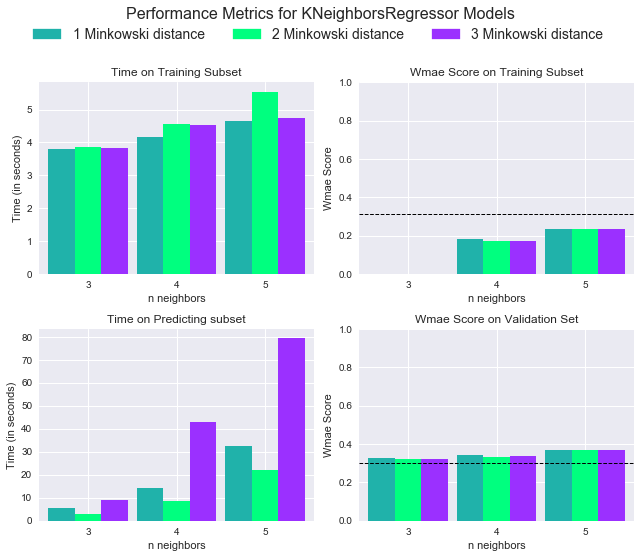

In [25]:
from time import time
from sklearn.neighbors import KNeighborsRegressor

reg_KNNs = []
for neighbors in [1, 2, 3]:
    for p in [1, 2, 3]:
        reg_KNNs.append(KNeighborsRegressor(n_jobs=-1, n_neighbors=neighbors, p=p))

samples_1 = int(0.01*len(labels_train))
samples_10 = int(0.1*len(labels_train))
samples_100 = len(labels_train)

start = time()
results_KNNs = {}
n = 1
for reg in reg_KNNs:
    print("{} {} trained on {} samples...".format(reg.__class__.__name__, n, samples_100))
    results_KNNs['{}'.format(n)] = train_predict(reg, samples_100, X_train, y_train, X_test, y_test, 0)
    n += 1
end = time()
print('KNN hand_search time:{:.4f}s'.format(end-start))

# print(results_KNNs)
plot_result_KNNs(results_KNNs, mean_wmae_train, mean_wmae_test)

KNeighborsRegressor 1 trained on 12000 samples...
{'train time': 3.739208936691284, 'prediction time': 19.89683723449707, 'train_wmae': 0.23397608535034256, 'test_wmae': 0.3675453925927657}


KNeighborsRegressor 2 trained on 12000 samples...
{'train time': 4.874609470367432, 'prediction time': 15.315627813339233, 'train_wmae': 0.23329335335278553, 'test_wmae': 0.36880391583415784}


KNeighborsRegressor 3 trained on 12000 samples...
{'train time': 5.316411018371582, 'prediction time': 76.12645602226257, 'train_wmae': 0.23427352300093748, 'test_wmae': 0.36939985603610814}


KNeighborsRegressor 4 trained on 12000 samples...
{'train time': 4.711609125137329, 'prediction time': 42.46447730064392, 'train_wmae': 0.2912099466924272, 'test_wmae': 0.3893951011053771}


KNeighborsRegressor 5 trained on 12000 samples...
{'train time': 4.718609571456909, 'prediction time': 29.02257013320923, 'train_wmae': 0.29260328392479684, 'test_wmae': 0.39638514036430206}


KNeighborsRegressor 6 trained on 1200

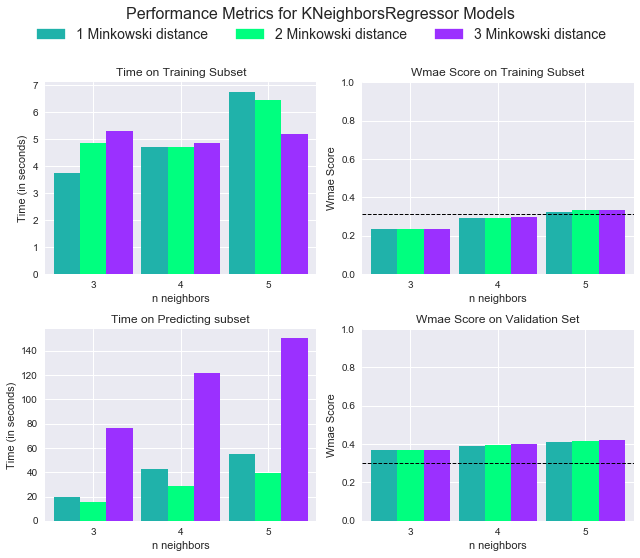

In [47]:
from time import time
from sklearn.neighbors import KNeighborsRegressor

reg_KNNs = []
for neighbors in [3, 4, 5]:
    for p in [1, 2, 3]:
        reg_KNNs.append(KNeighborsRegressor(n_jobs=-1, n_neighbors=neighbors, p=p))

samples_1 = int(0.01*len(labels_train))
samples_10 = int(0.1*len(labels_train))
samples_100 = len(labels_train)

start = time()
results_KNNs = {}
n = 1
for reg in reg_KNNs:
    print("{} {} trained on {} samples...".format(reg.__class__.__name__, n, samples_100))
    results_KNNs['{}'.format(n)] = train_predict(reg, samples_100, X_train, y_train, X_test, y_test, 0)
    n += 1
end = time()
print('KNN hand_search time:{:.4f}s'.format(end-start))

# print(results_KNNs)
plot_result_KNNs(results_KNNs, mean_wmae_train, mean_wmae_test)

In [49]:
X_train

,ord_cnt,sale_amt,offer_cnt,offer_amt,rtn_cnt,rtn_amt,user_cnt,charge,consume,cmmt_num,...,cate_301,cate_302,cate_303,cate_304,cate_305,cate_306,cate_307,cate_308,cate_309,cate_310
13136,1.051876,0.869188,1.070577,0.772327,0.585086,0.946445,1.052903,0.835871,0.000000,0.926375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3536,1.347833,1.104352,1.471274,1.355996,0.651753,0.912988,1.349510,1.123512,1.622722,1.114008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10296,1.401092,1.521789,1.507273,1.528570,1.391567,1.704592,1.402570,1.170535,1.725642,1.114869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2137,1.090085,0.953648,1.032718,0.784290,0.817915,1.143070,1.091668,0.000000,0.000000,0.860794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14775,1.084500,1.298253,1.221011,0.985967,0.670583,1.609990,1.086076,0.943613,1.405053,0.930299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10575,0.725969,0.652206,0.000000,0.000000,0.455285,0.909727,0.727024,0.000000,0.000000,0.617576,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11938,1.359959,1.254434,1.483332,1.377636,1.027338,1.289250,1.361801,0.725641,0.608392,1.179426,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11006,1.489681,1.371122,1.588591,1.473329,1.090204,1.328246,1.491007,0.000000,1.320603,1.327579,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7937,1.506801,1.370679,0.218247,0.483389,1.048703,1.351946,1.508424,0.000000,0.000000,1.197794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13178,0.818748,0.679020,0.275397,0.382449,0.558314,0.977437,0.819938,0.000000,0.000000,0.733619,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


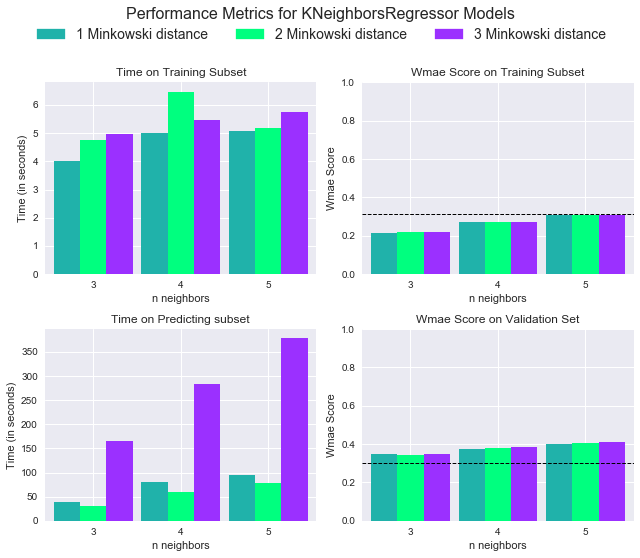

In [160]:
plot_result_KNNs(results_KNNs, mean_wmae_train, mean_wmae_test)

#### 6.2.2.3 预测并生成最终结果

In [161]:
reg_KNN_best = KNeighborsRegressor(n_jobs=-1, n_neighbors=3, p=2)
reg_KNN_best.fit(features.drop('shop_id', axis=1), labels)
predictions_KNN_best = reg_KNN_best.predict(features_test)

In [162]:
submission_rm_knn = pd.DataFrame()
submission_rm_knn['shop_id'] = range(1, 3001)
submission_rm_knn['pred_amt'] = predictions_KNN_best
submission_rm_knn = submission_rm_knn.groupby('shop_id')[['pred_amt']].mean()
submission_rm_knn.to_csv('submission_knn_3_full.csv', header=False)

**提交一** 6181111为**0.786665。**     

 **提交二：**KNN 为**0.582138**（val上为0.3965415249333668）（submission_rm_knn.csv）

**提交三**：KNN为**0.645001**（val上为0.30058163997452775）（submission_sklearn_1.csv）

**提交四**：KNN为**0.584953**（submission_knn_3_full.csv）